In [360]:
from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector, Gate
from qiskit import Aer
from typing import Union
from qiskit import assemble, transpile
from qiskit.circuit.library import TwoLocal
from qiskit.opflow import Z, I, X, Y
from qiskit.opflow import StateFn, CircuitStateFn
from qiskit.opflow import PauliExpectation, CircuitSampler
from qiskit.opflow import Gradient, NaturalGradient, QFI, Hessian
from qiskit.utils import QuantumInstance

import torch
import numpy as np

from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from matplotlib import pyplot as plt


In [361]:
# We will implement the efficientSU2 ansatz
def quanvolutionESU2(N_dims, gates=['rx', 'rz'], reps=1, entanglement='circular', insert_barrier=True):
    
    # Function to apply rotation gates to all of our qubits
    def rotation(gate, start):
        qc = QuantumCircuit(N_dims, name=gate)
        for i in range(N_dims):
            if gate == 'rx':
                qc.rx(parameters[start+i], i)
            if gate == 'ry':
                qc.ry(parameters[start+i], i)
            if gate == 'rz':
                qc.rz(parameters[start+i], i)
        return qc
    
    # Function apply the entanglement
    def entanglement(type=entanglement):
        qc = QuantumCircuit(N_dims, name=type)
        if (type == "circular"):
            qc.cx(N_dims-1, 0)
            for i in range(N_dims-1):
                target = i + 1
                qc.cx(i, target)
        if (type == "linear"):
            for i in range(N_dims - 1):
                target = i + 1
                qc.cx(i, target)
        if (type == "full"):
            for i in range(N_dims):
                for j in range(N_dims):
                    if (i != j):
                        qc.cx(i, j)
        return qc
    
    # Calculate the number of parameters we will need
    num_params = 2*len(gates)*N_dims*reps
    parameters = ParameterVector('theta', num_params)
    qc = QuantumCircuit(N_dims, name="EfficientSU2")
    start = 0
    
    for i in range(reps):
        for gate in gates:
            qc.compose(rotation(gate, start), range(N_dims), inplace=True)
            start += N_dims

        qc.compose(entanglement(), range(N_dims), inplace=True)
        
        if (reps == 1 or i == reps-1):
            if insert_barrier: qc.barrier()
            for gate in gates:
                qc.compose(rotation(gate, start), range(N_dims), inplace=True)
                start += N_dims
        if insert_barrier: qc.barrier()
    
    return qc

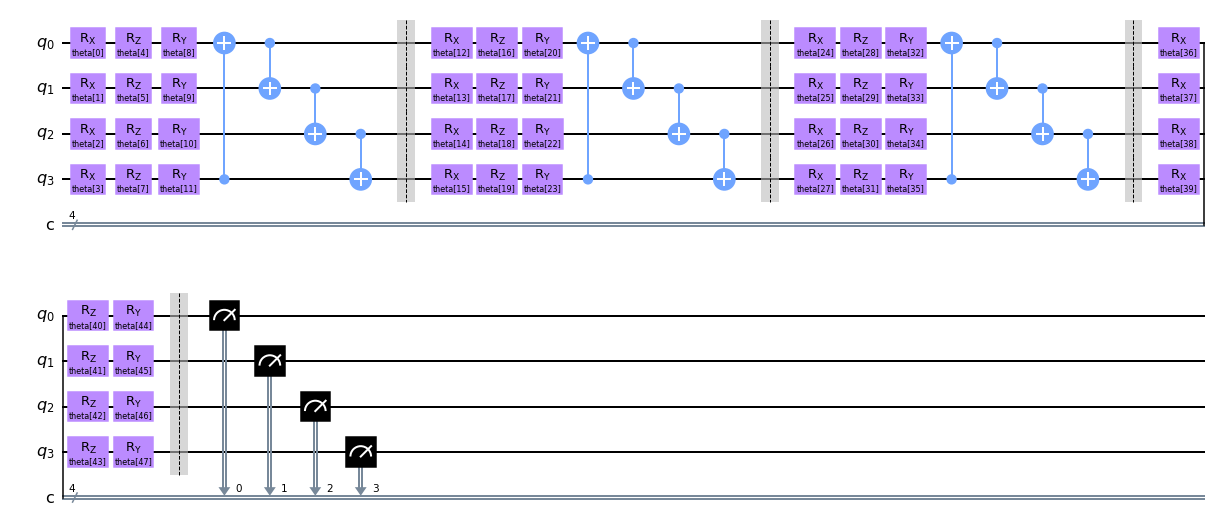

In [362]:
def randomLayer(numQbits, gates=['rx', 'rz', 'ry'], entanglement='linear', reps=1, to_gate=True) -> Union[Gate, QuantumCircuit]:
    qc = QuantumCircuit(numQbits)
    insert_barrier = False if to_gate else True 
    qc.compose(quanvolutionESU2(numQbits, gates=gates, entanglement=entanglement, reps=reps, 
                                insert_barrier=insert_barrier), inplace=True)
    return qc.to_gate(label="Random Layer") if to_gate else qc

n = 4
qc = QuantumCircuit(n,n)
qc.compose(randomLayer(n, reps=3, to_gate=False, entanglement='circular'), inplace=True)
qc.measure(range(n), range(n))
qc.draw('mpl')

In [363]:
class QC:
    """ 
    This class provides a simple interface for interaction 
    with the quantum circuit 
    """
    
    def __init__(self, n_qubits, backend, shots):
        # --- Circuit definition ---
        self._circuit = QuantumCircuit(n_qubits).compose(randomLayer(n_qubits))
        
        all_qubits = [i for i in range(n_qubits)]
        self.theta = self._circuit.parameters
        
        self.nParams = self._circuit.num_parameters
        
        self._circuit.measure_all()
        # ---------------------------

        self.backend = backend
        self.shots = shots
        
        self.q_instance = QuantumInstance(self.backend, shots = self.shots, seed_simulator = 2718, seed_transpiler = 2718)
        self.sampler = CircuitSampler(self.q_instance)
        self.shifter = Gradient()  # parameter-shift rule is the default
    
    def run(self, thetas):
        
        
        t_qc = transpile(self._circuit,
                         self.backend)
        qobj = assemble(t_qc,
                        shots=self.shots,
                        parameter_binds = [{self.theta[i]: theta for i,theta in enumerate(thetas)}])
        
        job = self.backend.run(qobj)
        result = job.result().get_counts()
        
        counts = np.array(list(result.values()))
        states = np.array(list(result.keys())).astype(float)
        
        # Compute probabilities for each state
        probabilities = counts / self.shots
        # Get state expectation
        expectation = np.sum(states * probabilities)
        
        return np.array([expectation])
    
    def grad(self, thetas):
        hamiltonian = Z ^ I ^ X ^ I ^ Y ^ I
        
        expectation = StateFn(hamiltonian, is_measurement=True) @ StateFn(self._circuit.remove_final_measurements(inplace=False))
        
        grad = self.shifter.convert(operator=expectation)
        
        return np.real(np.array(self.sampler.convert(grad, dict(zip(self.theta, thetas))).eval()))
        
    


In [370]:
class HybridFunction(Function):
    """ Hybrid quantum - classical function definition """
    
    @staticmethod
    def forward(ctx, input, quantum_circuit, shift):
        """ Forward pass computation """
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit
        expectation_z = ctx.quantum_circuit.run((input.tolist()))
        result = torch.tensor([expectation_z])
        ctx.save_for_backward(input, result)

        return result
        
    @staticmethod
    def backward(ctx, grad_output):
        """ Backward pass computation """
        input, expectation_z = ctx.saved_tensors
        input_list = np.array((input.tolist()))
        
        
        """shift_right = input_list + np.ones(input_list.shape) * ctx.shift
        shift_left = input_list - np.ones(input_list.shape) * ctx.shift
        
        print(shift_right)
        
        gradients = []
        for i in range(len(input_list)):
            expectation_right = ctx.quantum_circuit.run(shift_right[i])
            expectation_left  = ctx.quantum_circuit.run(shift_left[i])
            
            gradient = torch.tensor(expectation_right) - torch.tensor(expectation_left)
            print(gradient)
            gradients.append(gradient)
        gradients = np.array(gradients).T"""
        
        gradients = ctx.quantum_circuit.grad(input_list).T
        
        return torch.tensor([gradients]).float() * grad_output.float(), None, None

class Hybrid(nn.Module):
    """ Hybrid quantum - classical layer definition """
    
    def __init__(self, backend, shots, shift):
        super(Hybrid, self).__init__()
        self.qc = QC(1, backend, shots)
        self.shift = [np.pi/2 for i in range(self.qc.nParams)]
        
    def forward(self, input):
        return HybridFunction.apply(input, self.qc, self.shift)

In [320]:
# Concentrating on the first 100 samples
n_samples = 100

X_train = datasets.MNIST(root='./data', train=True, download=True,
                         transform=transforms.Compose([transforms.ToTensor()]))

# Leaving only labels 0 and 1 
idx = np.append(np.where(X_train.targets == 0)[0][:n_samples], 
                np.where(X_train.targets == 1)[0][:n_samples])

X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]

train_loader = torch.utils.data.DataLoader(X_train, batch_size=1, shuffle=True)

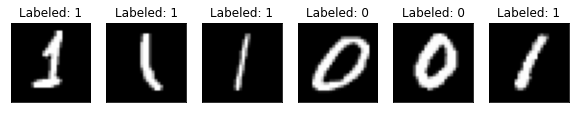

In [321]:
n_samples_show = 6

data_iter = iter(train_loader)
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

while n_samples_show > 0:
    images, targets = data_iter.__next__()

    axes[n_samples_show - 1].imshow(images[0].numpy().squeeze(), cmap='gray')
    axes[n_samples_show - 1].set_xticks([])
    axes[n_samples_show - 1].set_yticks([])
    axes[n_samples_show - 1].set_title("Labeled: {}".format(targets.item()))
    
    n_samples_show -= 1

In [322]:
n_samples = 50

X_test = datasets.MNIST(root='./data', train=False, download=True,
                        transform=transforms.Compose([transforms.ToTensor()]))

idx = np.append(np.where(X_test.targets == 0)[0][:n_samples], 
                np.where(X_test.targets == 1)[0][:n_samples])

X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]

test_loader = torch.utils.data.DataLoader(X_test, batch_size=1, shuffle=True)

In [323]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(256, 64)
        self.hybrid = Hybrid(Aer.get_backend('qasm_simulator'), 16, np.pi / 2)
        n = self.hybrid.qc.nParams
        self.fc2 = nn.Linear(64, n)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(1, -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.hybrid(x)
        return torch.cat((x, 1 - x), -1)

In [324]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

epochs = 20
loss_list = []

model.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        print(output, target)
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        total_loss.append(loss.item())
    loss_list.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(
        100. * (epoch + 1) / epochs, loss_list[-1]))

tensor([[0., 1.]], dtype=torch.float64, grad_fn=<CatBackward0>) tensor([0])
tensor([[0., 1.]], dtype=torch.float64, grad_fn=<CatBackward0>) tensor([0])
tensor([[0., 1.]], dtype=torch.float64, grad_fn=<CatBackward0>) tensor([1])
tensor([[0., 1.]], dtype=torch.float64, grad_fn=<CatBackward0>) tensor([0])
tensor([[0., 1.]], dtype=torch.float64, grad_fn=<CatBackward0>) tensor([1])
tensor([[0., 1.]], dtype=torch.float64, grad_fn=<CatBackward0>) tensor([0])
tensor([[0., 1.]], dtype=torch.float64, grad_fn=<CatBackward0>) tensor([0])
tensor([[0., 1.]], dtype=torch.float64, grad_fn=<CatBackward0>) tensor([0])
tensor([[0., 1.]], dtype=torch.float64, grad_fn=<CatBackward0>) tensor([1])
tensor([[0., 1.]], dtype=torch.float64, grad_fn=<CatBackward0>) tensor([1])
tensor([[0.0625, 0.9375]], dtype=torch.float64, grad_fn=<CatBackward0>) tensor([0])
tensor([[0., 1.]], dtype=torch.float64, grad_fn=<CatBackward0>) tensor([0])
tensor([[0., 1.]], dtype=torch.float64, grad_fn=<CatBackward0>) tensor([1])
tens

KeyboardInterrupt: 

Text(0, 0.5, 'Neg Log Likelihood Loss')

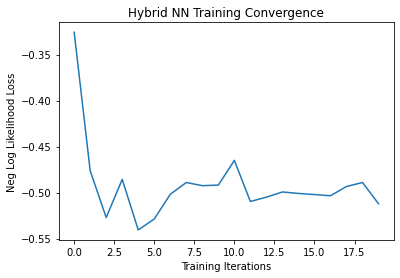

In [156]:
plt.plot(loss_list)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg Log Likelihood Loss')

In [365]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler



In [366]:
def load_iris_data():
    x, y = datasets.load_iris(return_X_y=True)

    # Reduce problem to binary classification
    is_class_2 = (y == 2) 
    x = x[~is_class_2]
    y = y[~is_class_2]
    #y = y * 2 - 1  # map form {0, 1} to Z expectation values of {-1,+1}

    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=0.2, shuffle=True, random_state=123
    )

    # Standardize data (i.e. mean of 0 with unit variance)
    std_scale = StandardScaler().fit(x_train)
    x_train = std_scale.transform(x_train)
    x_test = std_scale.transform(x_test)

    # Scale to between -1 and 1
    X_std = np.append(x_train, x_test, axis=0)
    minmax_scale = MinMaxScaler((0, 1)).fit(X_std)
    x_train = minmax_scale.transform(x_train)
    x_test = minmax_scale.transform(x_test)
    return x_train, x_test, y_train, y_test

In [367]:
x_train, x_test, y_train, y_test = load_iris_data()

x_train = torch.FloatTensor(x_train)
x_test = torch.FloatTensor(x_test)
y_train = torch.DoubleTensor(y_train)
y_test = torch.DoubleTensor(y_test)

tensor([[0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
      

In [371]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hybrid = Hybrid(Aer.get_backend('qasm_simulator'), 512, np.pi / 4)
        n = self.hybrid.qc.nParams
        self.fc1 = nn.Linear(4, n)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.hybrid(x)
        x = torch.sigmoid(x)
        return x

In [373]:
model = Net()
optimizer = optim.Adam(model.parameters())
loss_func = nn.BCELoss()
epochs = 20
loss_list = []

model.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(zip(x_train, y_train.reshape(-1,1))):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output[0], target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()

        total_loss.append(loss.item())
    loss_list.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(
        100. * (epoch + 1) / epochs, loss_list[-1]))

Training [5%]	Loss: 0.6548
Training [10%]	Loss: 0.6490
Training [15%]	Loss: 0.6414
Training [20%]	Loss: 0.6399
Training [25%]	Loss: 0.6385
Training [30%]	Loss: 0.6377
Training [35%]	Loss: 0.6309
Training [40%]	Loss: 0.6197
Training [45%]	Loss: 0.6089
Training [50%]	Loss: 0.6006
Training [55%]	Loss: 0.5994
Training [60%]	Loss: 0.6000
Training [65%]	Loss: 0.6027
Training [70%]	Loss: 0.6107
Training [75%]	Loss: 0.6148
Training [80%]	Loss: 0.6284
Training [85%]	Loss: 0.6486
Training [90%]	Loss: 0.6650
Training [95%]	Loss: 0.6766
Training [100%]	Loss: 0.6858


Text(0, 0.5, 'Neg Log Likelihood Loss')

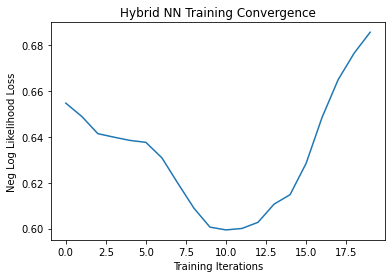

In [375]:
plt.plot(loss_list)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg Log Likelihood Loss')

In [377]:
preds = []
with torch.no_grad():
    for val in x_test:
        y_hat = model.forward(val)
        preds.append(y_hat.argmax().item())

In [378]:
print(np.sum[1 if preds[i] == y_test[i] else 0 for i in range(len(y_test))] / len(y_test))

SyntaxError: invalid syntax (Temp/ipykernel_28648/3865134290.py, line 1)